In [814]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn import mixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_seed=5000

In [815]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [816]:
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)

Benign Count:  357
Malignant Count:  212


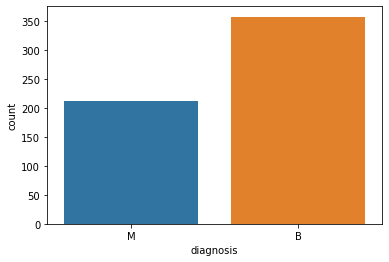

In [817]:
B, M = y.value_counts()

sns.countplot(y)
print("Benign Count: ", B)
print("Malignant Count: ", M)

In [818]:
x = StandardScaler().fit_transform(x)

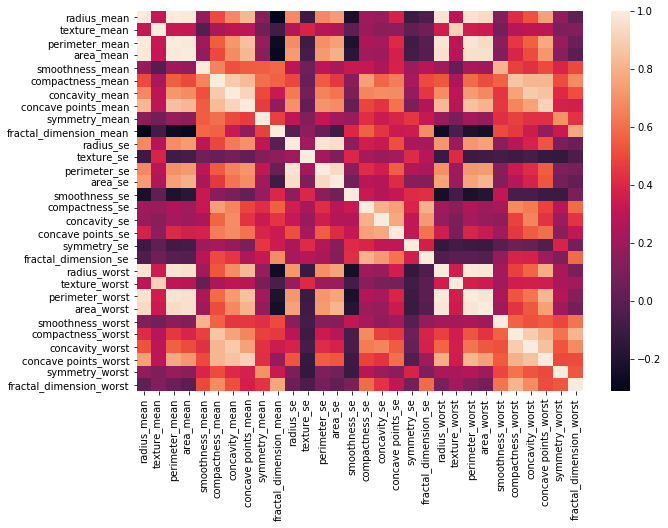

In [891]:
plt.figure(figsize=(10,7))
sns.heatmap(data[data.columns[0:]].corr())
plt.savefig('BCPairplot.png')

In [820]:
y = y.apply(lambda q: 0 if q == 'B' else 1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Curves

In [821]:
def plot_learning_curve(classifier, x, y, title):
    n = len(y)
    train_size = np.linspace(0.1, 1.0, 20)
    
    _, train_scores, test_scores = learning_curve(classifier, x, y, scoring='f1', train_sizes=train_size, cv=5)
    plt.figure()
    plt.plot(train_size, np.mean(train_scores, axis=1), 'o-', label="Training Score")
    plt.plot(train_size, np.mean(test_scores, axis=1), 'o-', label="Cross-Validation Score")
    plt.title(title)
    plt.xlabel("Fraction of DataSet")
    plt.ylabel("Classification Score")
    plt.legend(loc="best")
    plt.grid(axis='both')
    
    # plt.savefig('SVMLineartuned.png')
    
def plot_validation_curve(classifier, x, y, p, p_range, cv, title, attribute):
    train, test = validation_curve(classifier, x, y, param_name=p, param_range=p_range, cv=cv)
    
    title = 'Validation Curve for ' + title
    
    plt.figure(figsize=(7,5))
    plt.plot(p_range, np.mean(train, axis=1), label='Training Score')
    plt.plot(p_range, np.mean(test, axis=1), label='CV Score')
    plt.title(title)
    plt.xlabel(attribute)
    plt.ylabel('Classification Score')
    plt.legend(loc='best')
    plt.grid()
    
    # plt.savefig('CancerLinearCMCC.png')

# Experiment 1

#### K Means Clustering

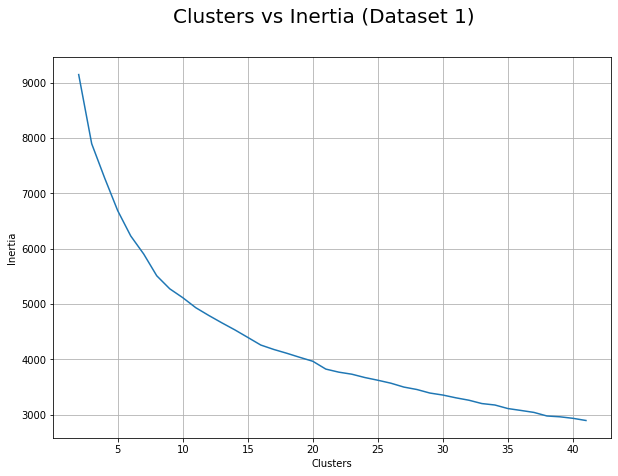

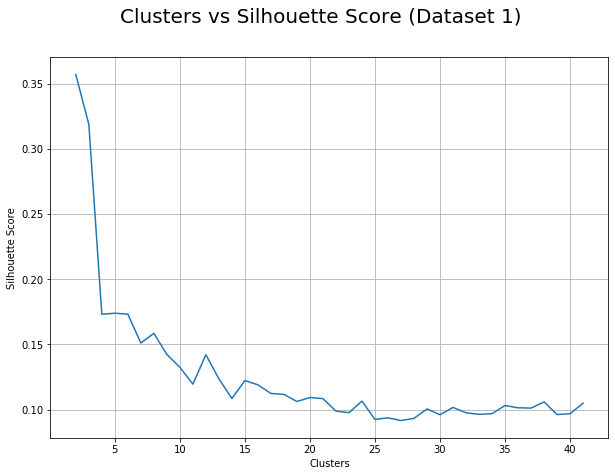

In [822]:
clusters = 2 + np.arange(40)

scores = []
init_inertia = []
init_silhouette = []
i=0

for cluster in clusters:
    classifier = KMeans(n_clusters=cluster, max_iter=1000, random_state=random_seed)
    classifier = classifier.fit(X_real_train, y_real_train)
    init_inertia.append(classifier.inertia_)
    init_silhouette.append(silhouette_score(X_real_train, classifier.labels_))
    
    y_pred = classifier.predict(X_real_test)
    accuracy = metrics.accuracy_score(y_pred, y_real_test)
    
    scores.append(accuracy)
    i += 1
    
    
plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Inertia (Dataset 1)", fontsize=20)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.plot(clusters, init_inertia)
plt.grid()
plt.show()


plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Silhouette Score (Dataset 1)", fontsize=20)
plt.ylabel("Silhouette Score")
plt.xlabel("Clusters")
plt.plot(clusters, init_silhouette)
plt.grid()
plt.show()

#### Using best Elbow and Slihouette Number of Clusters

In [830]:
elbow = 6
silhouette = 2

print("===========================")
print("Elbow Method: ")
classifier = KMeans(n_clusters=elbow, max_iter=1000, random_state=random_seed)
classifier = classifier.fit(X_real_train, y_real_train)
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

print("===========================")
print("Silhouette Method: ")
classifier_2 = KMeans(n_clusters=silhouette, max_iter=1000, random_state=random_seed)
classifier_2.fit(X_real_train, y_real_train)
y_pred = classifier_2.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

print("===========================")
print("END")

Elbow Method: 
Accuracy:  0.18421052631578946
Silhouette Method: 
Accuracy:  0.06140350877192982
END


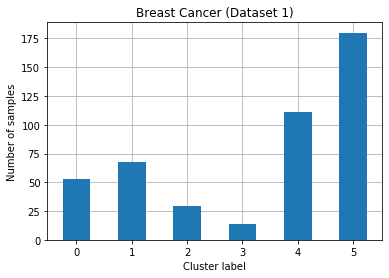

In [834]:
plt.figure()
plt.hist(classifier.labels_, bins=np.arange(0, elbow + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, elbow))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.title('Breast Cancer (Dataset 1)')
plt.grid()
plt.savefig('BCDistribution.png')

### EM

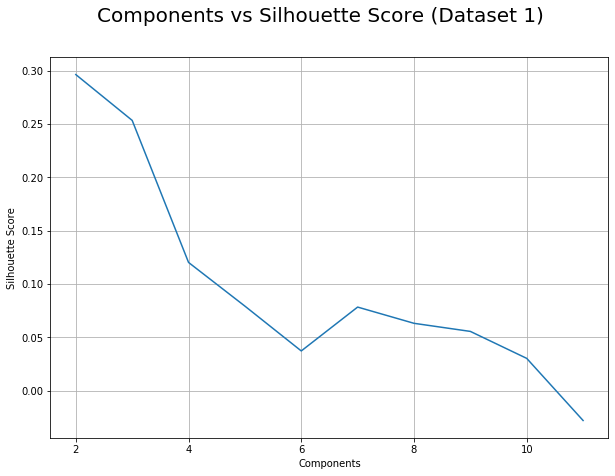

In [524]:
clusters = 2 + np.arange(10)
scores = []
i=0

for cluster in clusters:
    classifier = GaussianMixture(n_components=cluster, max_iter=1000, random_state=random_seed)
    classifier = classifier.fit(X_real_train, y_real_train)
    curr_y = classifier.predict(X_real_test)
    
    scores.append(silhouette_score(X_real_test, curr_y))
    accuracy = metrics.accuracy_score(y_pred, y_real_test)
    
    i += 1


plt.figure(figsize=(10, 7))
plt.suptitle("Components vs Silhouette Score (Dataset 1)", fontsize=20)
plt.ylabel("Silhouette Score")
plt.xlabel("Components")
plt.plot(clusters, scores)
plt.grid()
plt.savefig('BCEMSilhouette.png')
plt.show()

#### BIC Score

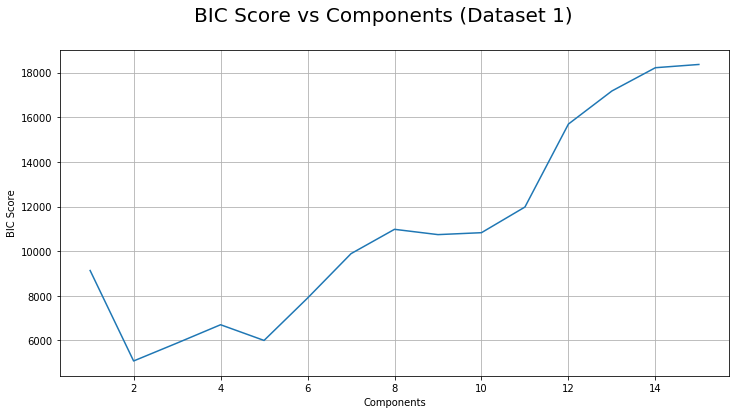

In [525]:
init_bic = []
components = 1 + np.arange(15)

for component in components:
    gmm = GaussianMixture(n_components=component, max_iter=1000, 
                              covariance_type=cv_type, random_state=random_seed)
    gmm.fit(X_real_train, y_real_train)
    init_bic.append(gmm.bic(X_real_train))
        
init_bic = np.array(init_bic)

plt.figure(figsize=(12, 6))
plt.suptitle('BIC Score vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Components')
plt.ylabel('BIC Score')
plt.plot(components, init_bic)
plt.grid()
# plt.savefig('BCEMBIC.png')
plt.show()

#### Testing Best number of Components

In [836]:
components = 2
classifier = GaussianMixture(n_components=components, max_iter=1000, random_state=random_seed)
classifier.fit(X_real_train, y_real_train)
curr_y = classifier.predict(X_real_test)
    
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

Accuracy:  0.06140350877192982


# Dimensionality Reduction

### PCA

In [837]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

#### K Means

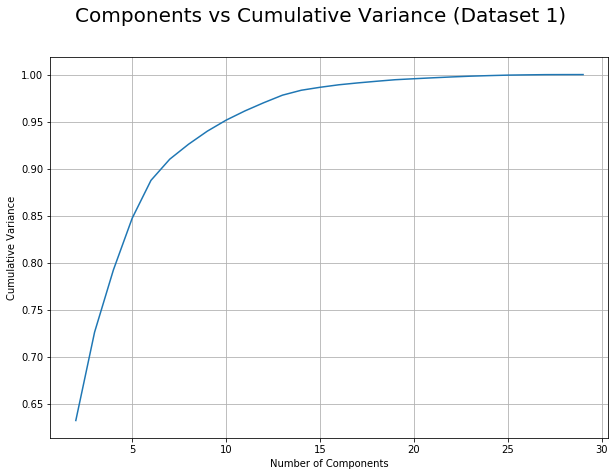

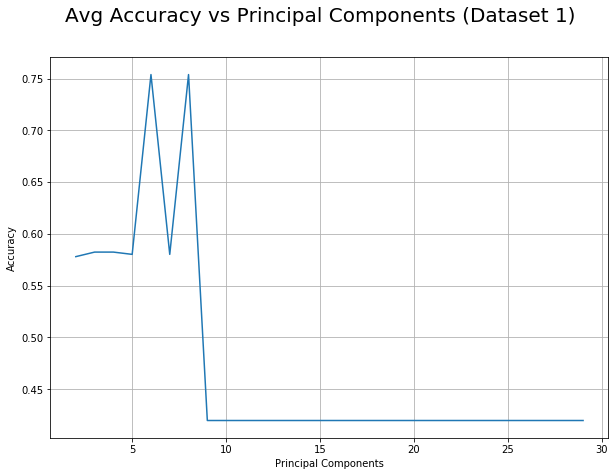

In [839]:
components = 2 + np.arange(28)
var = []
fin_acc = []
t = []

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    pca = PCA(n_components = component, random_state=random_seed)
    principalComponents = pca.fit_transform(x)
    var.append(sum(pca.explained_variance_ratio_))
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        principalComponents, y, test_size=0.2, random_state=random_seed)
    
    classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10,7))
plt.suptitle('Components vs Cumulative Variance (Dataset 1)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.plot(components, var)
plt.grid()
plt.savefig('BCPCAVariance.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Principal Components (Dataset 1)', fontsize=20)
plt.xlabel('Principal Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
# plt.savefig('BCPCAAccuracy.png')
plt.show()

#### Reproducing

In [845]:
pca = PCA(n_components = 6, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.22310781478881836
Testing Accuracy:  0.9122807017543859


#### Metrics

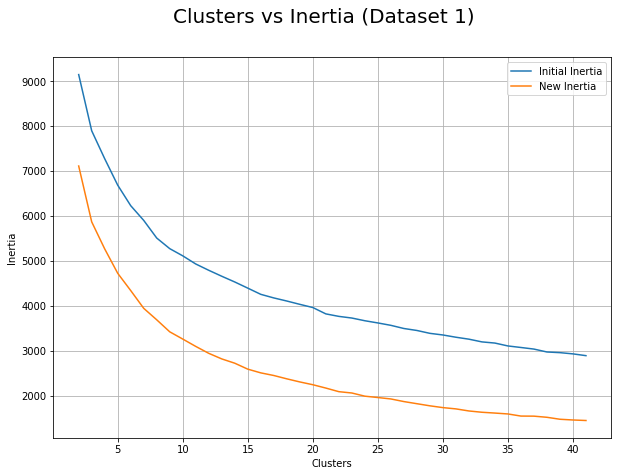

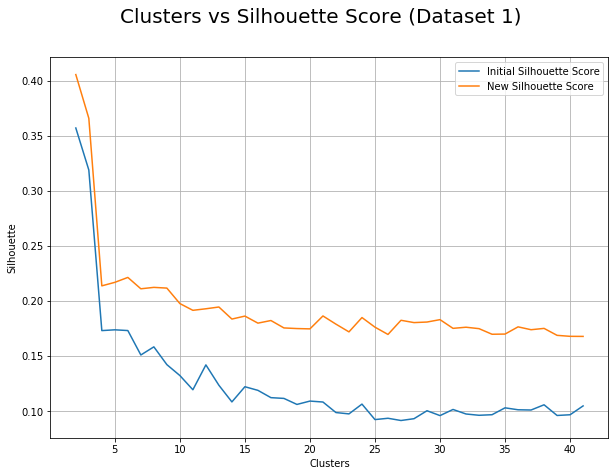

In [601]:
clusters = 2 + np.arange(40)

scores = []
inertia = []
silhouette = []
i=0

pca = PCA(n_components = 5, random_state=random_seed)
principalComponents = pca.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)

for cluster in clusters:
    classifier = KMeans(n_clusters=cluster, max_iter=1000, random_state=random_seed)
    classifier = classifier.fit(X_real_train, y_real_train)
    inertia.append(classifier.inertia_)
    silhouette.append(silhouette_score(X_real_train, classifier.labels_))
    
    y_pred = classifier.predict(X_real_test)
    accuracy = metrics.accuracy_score(y_pred, y_real_test)
    
    scores.append(accuracy)
    i += 1
    
    
plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Inertia (Dataset 1)", fontsize=20)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.plot(clusters, init_inertia, label='Initial Inertia')
plt.plot(clusters, inertia, label='New Inertia')
plt.grid()
plt.legend()
# plt.savefig('BCClusteringInertia.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Silhouette Score (Dataset 1)", fontsize=20)
plt.xlabel("Clusters")
plt.ylabel("Silhouette")
plt.plot(clusters, init_silhouette, label='Initial Silhouette Score')
plt.plot(clusters, silhouette, label='New Silhouette Score')
plt.grid()
plt.legend()
# plt.savefig()
plt.show()

#### EM

In [841]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

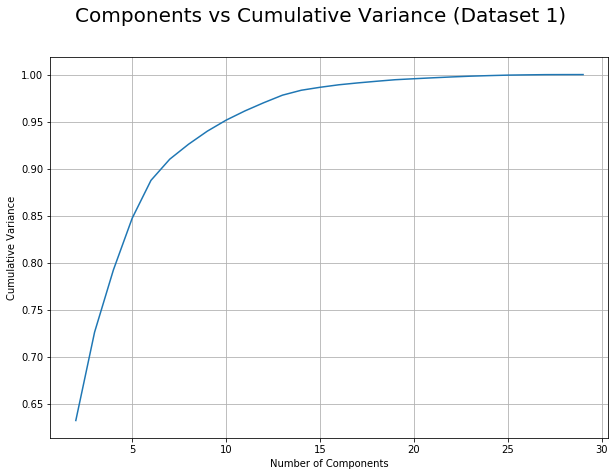

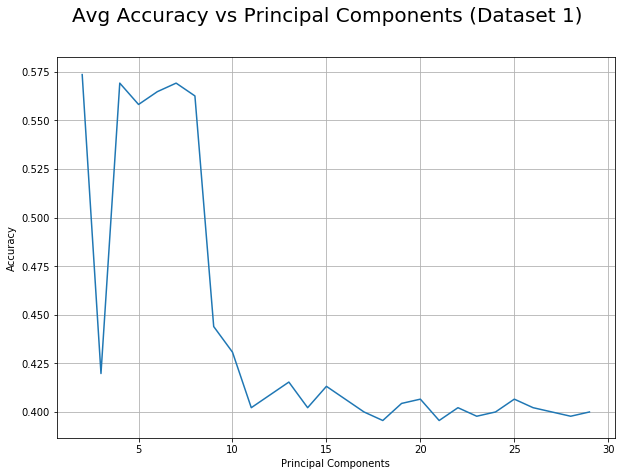

In [846]:
components = 2 + np.arange(28)
var = []
fin_acc = []
t = []

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    pca = PCA(n_components = component, random_state=random_seed)
    principalComponents = pca.fit_transform(x)
    var.append(sum(pca.explained_variance_ratio_))
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        principalComponents, y, test_size=0.2, random_state=random_seed)
    
    classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10,7))
plt.suptitle('Components vs Cumulative Variance (Dataset 1)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.plot(components, var)
plt.grid()
# plt.savefig('BCPCA.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Principal Components (Dataset 1)', fontsize=20)
plt.xlabel('Principal Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [847]:
pca = PCA(n_components = 6, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.11230683326721191
Testing Accuracy:  0.7982456140350878


#### Metrics

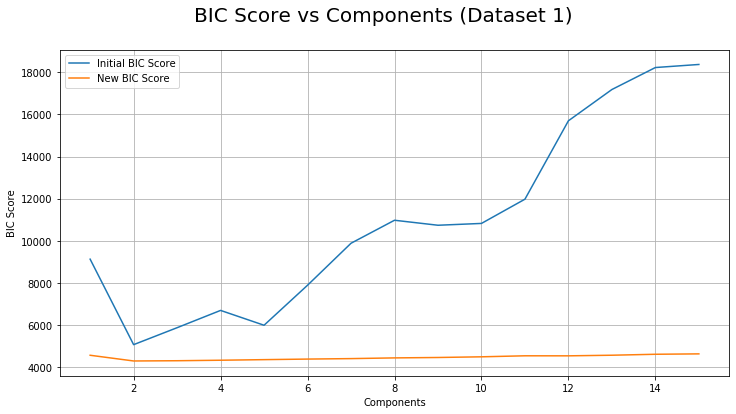

In [848]:
bic = []
components = 1 + np.arange(15)

pca = PCA(n_components = 2, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)

for component in components:
    gmm = GaussianMixture(n_components=component, max_iter=1000, 
                              covariance_type=cv_type, random_state=random_seed)
    gmm.fit(X_real_train, y_real_train)
    bic.append(gmm.bic(X_real_train))
        
bic = np.array(bic)

plt.figure(figsize=(12, 6))
plt.suptitle('BIC Score vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Components')
plt.ylabel('BIC Score')
plt.plot(components, init_bic, label='Initial BIC Score')
plt.plot(components, bic, label='New BIC Score')
plt.legend()
plt.grid()
# plt.savefig('BCEMBIC.png')
plt.show()

### Neural Network

In [885]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

Total Time Taken:  3.538001775741577
Testing Accuracy:  0.9912280701754386


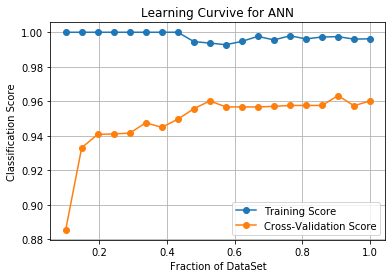

In [887]:
## With regular feature space
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")
plt.savefig('BCOriginalNN.png')


Total Time Taken:  3.762691020965576
Testing Accuracy:  0.956140350877193


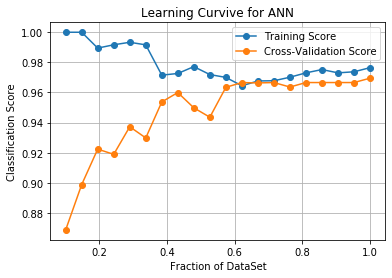

In [889]:
## With K Means feature space

pca = PCA(n_components = 6, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, alpha=0.0042, 
                           max_iter=5000, hidden_layer_sizes=(9,))

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")
plt.savefig('BCPCANN.png')

#### Hyperparameter Tuning

In [636]:
## Tuning

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

alpha = np.linspace(0.0001, 0.01, 100)

parameters = [{'alpha': alpha}]


t0 = time.time()
print("Searching:")
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes=(9,), max_iter=5000), parameters, 'f1')
classifier.fit(X_real_train, y_real_train)
t1 = time.time()
total_time = t1 - t0

print("Total time taken: ", total_time)
print(classifier.best_params_)

Searching:
Total time taken:  214.4607288837433
{'alpha': 0.004200000000000001}


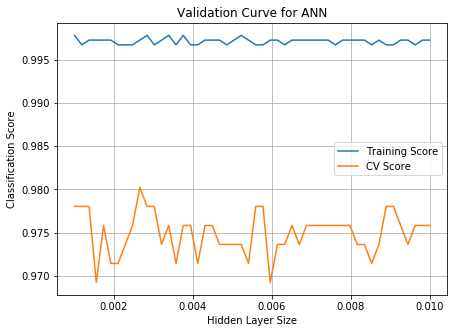

In [637]:
## Validation Curve

parameter = 'alpha'
parameter_range = np.linspace(0.001, 0.01, 50)
plot_validation_curve(MLPClassifier(max_iter=5000),
                      X_real_train, y_real_train, 
                      parameter, parameter_range, cv=5, title='ANN', 
                      attribute="Hidden Layer Size")

In [639]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

Total Time Taken:  2.8038558959960938
Testing Accuracy:  0.9122807017543859


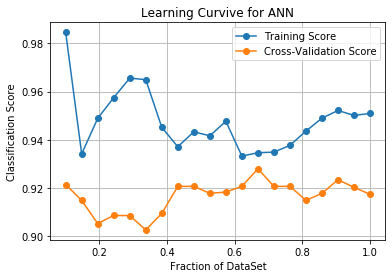

In [704]:
## With EM Feature space

pca = PCA(n_components = 2, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
i = 1
start_time = time.time()
classifier = MLPClassifier(hidden_layer_sizes=(15,), alpha=0.0001, random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

#### Hyperparameter Tuning

In [703]:
## Tuning

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)

alpha = np.arange(0.0001, 0.01, 100)

parameters = [{'alpha': alpha}]


t0 = time.time()
print("Searching:")
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes=(15,), max_iter=5000), parameters, 'f1')
classifier.fit(X_real_train, y_real_train)
t1 = time.time()
total_time = t1 - t0

print("Total time taken: ", total_time)
print(classifier.best_params_)

Searching:
Total time taken:  3.3377180099487305
{'alpha': 0.0001}


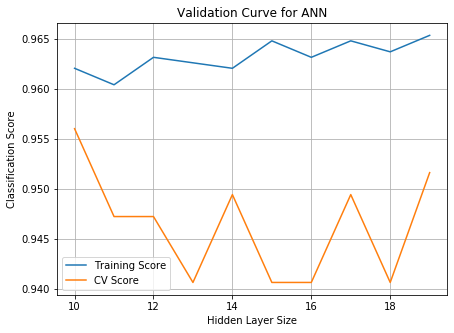

In [701]:
## Validation Curve

parameter = 'hidden_layer_sizes'
parameter_range = np.arange(10, 20, 1)
plot_validation_curve(MLPClassifier(max_iter=5000),
                      X_real_train, y_real_train, 
                      parameter, parameter_range, cv=5, title='ANN', 
                      attribute="Hidden Layer Size")

# ICA

In [890]:
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)

y = y.apply(lambda q: 0 if q == 'B' else 1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

#### K Means

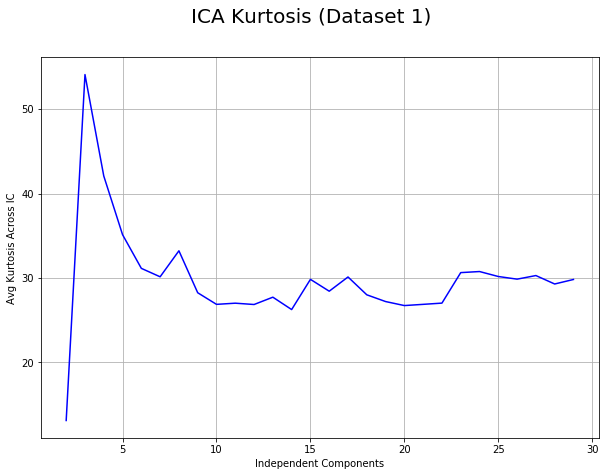

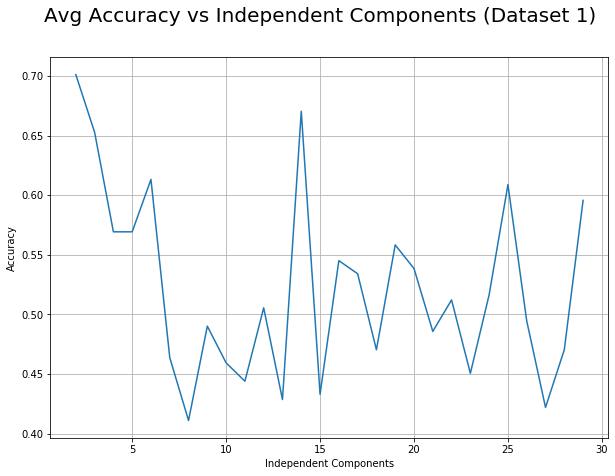

In [851]:
components = 2 + np.arange(28)
var = []
fin_acc = []
t = []
kurt=[]

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    transformer = FastICA(n_components = component, whiten=True, random_state=random_seed)
    X_transformed = transformer.fit_transform(x)
    tmp = pd.DataFrame(X_transformed)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_transformed, y, test_size=0.2, random_state=random_seed)
    
    classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10, 7))
plt.suptitle("ICA Kurtosis (Dataset 1)", fontsize=20)
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across IC")
plt.plot(components, kurt, 'b-')
plt.savefig('BCKurtosis.png')
plt.grid()
plt.show()


plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Independent Components (Dataset 1)', fontsize=20)
plt.xlabel('Independent Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [852]:
var = []
fin_acc = []
t = []

transformer = FastICA(n_components = 3, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.23337507247924805
Testing Accuracy:  0.8333333333333334


#### EM

Number of components:  2
Shape:  (569, 2)
Average Accuracy:  0.5912087912087912
Number of components:  3
Shape:  (569, 3)
Average Accuracy:  0.589010989010989
Number of components:  4
Shape:  (569, 4)
Average Accuracy:  0.41538461538461535
Number of components:  5
Shape:  (569, 5)
Average Accuracy:  0.5934065934065934
Number of components:  6
Shape:  (569, 6)
Average Accuracy:  0.23736263736263735
Number of components:  7
Shape:  (569, 7)
Average Accuracy:  0.5846153846153845
Number of components:  8
Shape:  (569, 8)
Average Accuracy:  0.4131868131868132
Number of components:  9
Shape:  (569, 9)
Average Accuracy:  0.5560439560439561
Number of components:  10
Shape:  (569, 10)
Average Accuracy:  0.3978021978021978
Number of components:  11
Shape:  (569, 11)
Average Accuracy:  0.5736263736263736
Number of components:  12
Shape:  (569, 12)
Average Accuracy:  0.421978021978022
Number of components:  13
Shape:  (569, 13)
Average Accuracy:  0.5824175824175823
Number of components:  14
Shape:

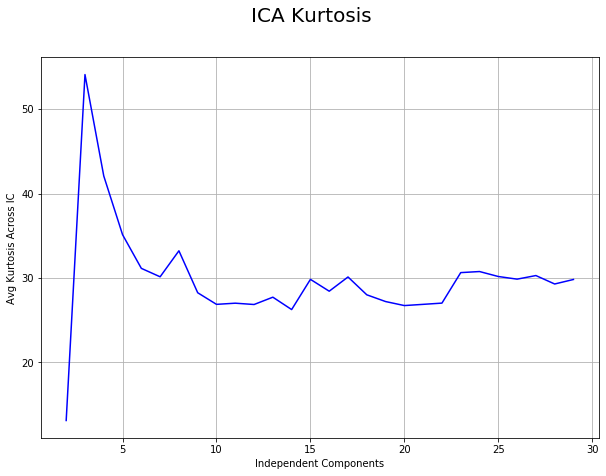

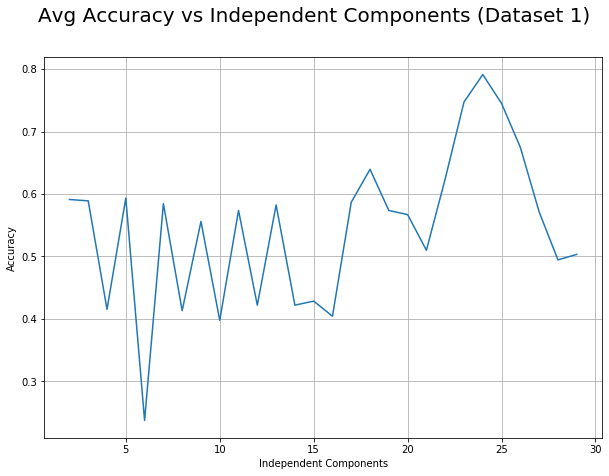

In [710]:
components = 2 + np.arange(28)
var = []
fin_acc = []
t = []
kurt=[]

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
    print("==============================")
    print("Number of components: ", component)
    
    transformer = FastICA(n_components = component, random_state=random_seed)
    X_transformed = transformer.fit_transform(x)
    tmp = pd.DataFrame(X_transformed)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())
    print("Shape: ", X_transformed.shape)
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_transformed, y, test_size=0.2, random_state=random_seed)
    
    classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
    print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10, 7))
plt.suptitle("ICA Kurtosis", fontsize=20)
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across IC")
plt.plot(components, kurt, 'b-')
plt.grid()
plt.show()


plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Independent Components (Dataset 1)', fontsize=20)
plt.xlabel('Independent Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [853]:
var = []
fin_acc = []
t = []

transformer = FastICA(n_components = 3, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.08467316627502441
Testing Accuracy:  0.9210526315789473


### Neural Network

Total Time Taken:  9.648865938186646
Testing Accuracy:  0.8947368421052632


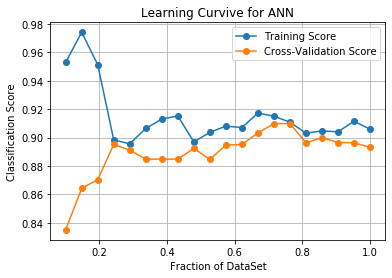

In [717]:
transformer = FastICA(n_components=3, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=random_seed)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(hidden_layer_sizes=(91,), random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

#### Hyperparameter Tuning

In [718]:
## Tuning

transformer = FastICA(n_components=3, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=random_seed)

alpha = np.arange(0.0001, 0.01, 100)

parameters = [{'alpha': alpha}]


t0 = time.time()
print("Searching:")
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes=(91,), max_iter=5000), parameters, 'f1')
classifier.fit(X_real_train, y_real_train)
t1 = time.time()
total_time = t1 - t0

print("Total time taken: ", total_time)
print(classifier.best_params_)

Searching:
Total time taken:  13.171572923660278
{'alpha': 0.0001}


In [ ]:
## Validation Curve

parameter = 'hidden_layer_sizes'
parameter_range = np.arange(10, 20, 1)
plot_validation_curve(MLPClassifier(max_iter=5000),
                      X_real_train, y_real_train, 
                      parameter, parameter_range, cv=5, title='ANN', 
                      attribute="Hidden Layer Size")

Total Time Taken:  8.728503942489624
Testing Accuracy:  0.8947368421052632


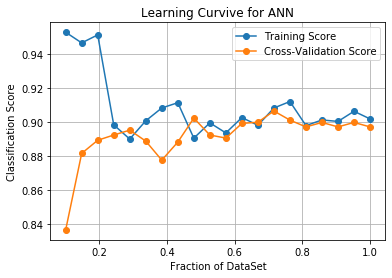

In [719]:
## NN for EM

transformer = FastICA(n_components=2, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=random_seed)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

# Random Projection

In [854]:
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)

y = y.apply(lambda q: 0 if q == 'B' else 1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

### K Means

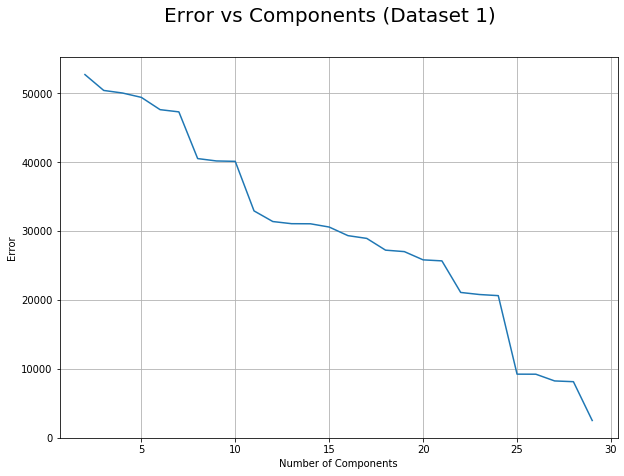

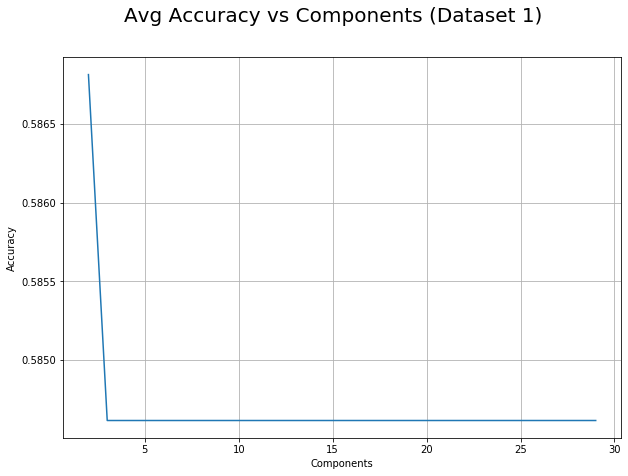

In [857]:
error = []
fin_acc = []
components = 2 + np.arange(28)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    transformer = GaussianRandomProjection(n_components=component, random_state=random_seed)
    X_new = transformer.fit_transform(x)
    temp = np.linalg.pinv(transformer.components_.T)
    reconstructed = np.dot(X_new, temp)
    err = mean_squared_error(x, reconstructed)
    error.append(err)
    
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_new, y, test_size=0.2, random_state=random_seed)
    
    classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        

plt.figure(figsize=(10, 7))
plt.suptitle('Error vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('Error')
plt.plot(components, error)
plt.savefig('BCReconstruction.png')
plt.grid()
plt.show()
        
plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [858]:
var = []
fin_acc = []
t = []

transformer = GaussianRandomProjection(n_components=15, random_state=random_seed)
X_new = transformer.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_new, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.24549508094787598
Testing Accuracy:  0.8245614035087719


### EM

In [859]:
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)

y = y.apply(lambda q: 0 if q == 'B' else 1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

Number of components:  2
Average Accuracy:  0.5956043956043956
Number of components:  3
Average Accuracy:  0.6021978021978022
Number of components:  4
Average Accuracy:  0.5956043956043956
Number of components:  5
Average Accuracy:  0.5912087912087912
Number of components:  6
Average Accuracy:  0.5890109890109889
Number of components:  7
Average Accuracy:  0.5824175824175823
Number of components:  8
Average Accuracy:  0.5934065934065934
Number of components:  9
Average Accuracy:  0.5846153846153846
Number of components:  10
Average Accuracy:  0.5802197802197802
Number of components:  11
Average Accuracy:  0.5736263736263736
Number of components:  12
Average Accuracy:  0.5692307692307692
Number of components:  13
Average Accuracy:  0.5846153846153846
Number of components:  14
Average Accuracy:  0.5714285714285714
Number of components:  15
Average Accuracy:  0.5758241758241759
Number of components:  16
Average Accuracy:  0.578021978021978
Number of components:  17
Average Accuracy:  0.58

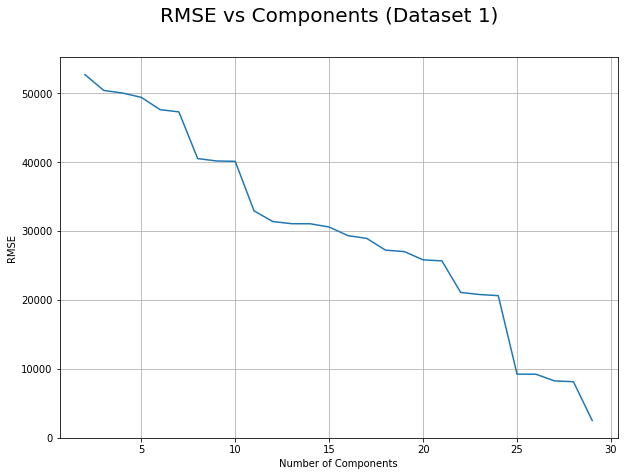

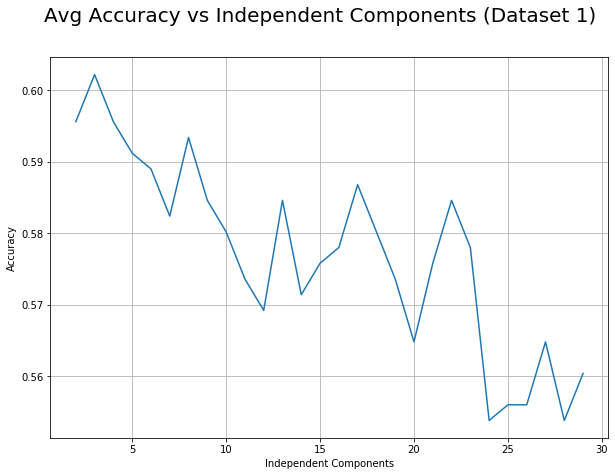

In [663]:
error = []
fin_acc = []
components = 2 + np.arange(28)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
    print("==============================")
    print("Number of components: ", component)
    
    transformer = GaussianRandomProjection(n_components=component, random_state=random_seed)
    X_new = transformer.fit_transform(x)
    temp = np.linalg.pinv(transformer.components_.T)
    reconstructed = np.dot(X_new, temp)
    err = mean_squared_error(x, reconstructed)
    error.append(err)
    
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_new, y, test_size=0.2, random_state=random_seed)
    
    classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
    print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        

plt.figure(figsize=(10, 7))
plt.suptitle('RMSE vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.plot(components, error)
plt.grid()
plt.show()
        
plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Independent Components (Dataset 1)', fontsize=20)
plt.xlabel('Independent Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [860]:
var = []
fin_acc = []
t = []

transformer = GaussianRandomProjection(n_components=15, random_state=random_seed)
X_new = transformer.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_new, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.18456292152404785
Testing Accuracy:  0.9298245614035088


### Neural Network

Total Time Taken:  4.013648271560669
Testing Accuracy:  0.8947368421052632


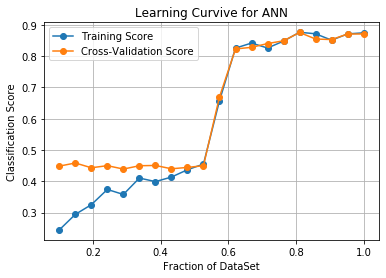

In [727]:
transformer = GaussianRandomProjection(n_components=2, random_state=random_seed)
X_new = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_new, y, test_size=0.2, random_state=random_seed)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(hidden_layer_sizes=(13,), random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

#### Hyperparameter Tuning

In [748]:
## Tuning

transformer = GaussianRandomProjection(n_components=2, random_state=random_seed)
X_new = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_new, y, test_size=0.2, random_state=random_seed)

activation = ['relu', 'logistic', 'tanh']

parameters = [{'activation': activation}]


t0 = time.time()
print("Searching:")
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes=(13,), max_iter=5000), parameters, 'f1')
classifier.fit(X_real_train, y_real_train)
t1 = time.time()
total_time = t1 - t0

print("Total time taken: ", total_time)
print(classifier.best_params_)

Searching:
Total time taken:  8.133882761001587
{'activation': 'relu'}


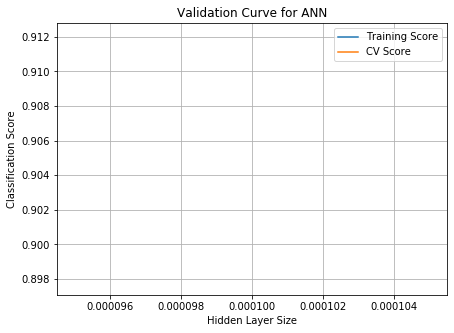

In [730]:
## Validation Curve

parameter = 'alpha'
parameter_range = np.arange(0.0001, 0.01, 1000)
plot_validation_curve(MLPClassifier(hidden_layer_sizes=(13,), max_iter=5000),
                      X_real_train, y_real_train, 
                      parameter, parameter_range, cv=5, title='ANN', 
                      attribute="Hidden Layer Size")

# Random Forest Classifier

In [880]:
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)

y = y.apply(lambda q: 0 if q == 'B' else 1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

### K Means

In [881]:
rfc = RandomForestClassifier(n_estimators=500, min_samples_leaf=round(
        len(x)*.01), random_state=random_seed)

new_x = rfc.fit(x, y).feature_importances_
new_x = pd.DataFrame(
        new_x, columns=['Feature Importance'], index=x.columns[0::])
new_x.sort_values(by=['Feature Importance'], inplace=True, ascending=False)

new_x['Cum Sum'] = new_x['Feature Importance'].cumsum()
new_x = new_x[new_x['Cum Sum'] <= 0.9]
best_columns = new_x.index.tolist()


In [884]:
rfc_x = x[best_columns]
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(rfc_x, y, test_size=0.2, random_state=0)
rfc_x.head()

,concave points_worst,perimeter_worst,area_worst,concave points_mean,radius_worst,perimeter_mean,area_mean,concavity_mean,radius_mean,concavity_worst,area_se,radius_se
0,0.2654,184.60,2019.0,0.14710,25.38,122.80,1001.0,0.3001,17.99,0.7119,153.40,1.0950
1,0.1860,158.80,1956.0,0.07017,24.99,132.90,1326.0,0.0869,20.57,0.2416,74.08,0.5435
2,0.2430,152.50,1709.0,0.12790,23.57,130.00,1203.0,0.1974,19.69,0.4504,94.03,0.7456
3,0.2575,98.87,567.7,0.10520,14.91,77.58,386.1,0.2414,11.42,0.6869,27.23,0.4956
4,0.1625,152.20,1575.0,0.10430,22.54,135.10,1297.0,0.1980,20.29,0.4000,94.44,0.7572


### K Means

In [883]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]

    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.23916316032409668
Testing Accuracy:  0.8245614035087719


### EM

In [735]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]

    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.14464712142944336
Testing Accuracy:  0.9298245614035088


### Neural Network

Total Time Taken:  1.2407526969909668
Testing Accuracy:  0.9035087719298246


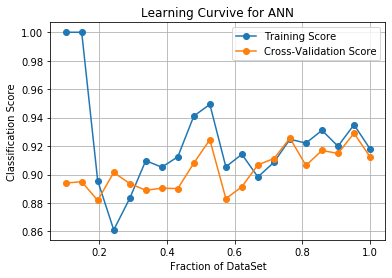

In [742]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    rfc_x, y, test_size=0.2, random_state=random_seed)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(hidden_layer_sizes=(65,), random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

#### Hyperparameter Tuning

In [747]:
## Tuning

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    rfc_x, y, test_size=0.2, random_state=random_seed)

activation = ['relu', 'logistic', 'tanh']

parameters = [{'activation': activation}]


t0 = time.time()
print("Searching:")
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes=(65,), max_iter=5000), parameters, 'f1')
classifier.fit(X_real_train, y_real_train)
t1 = time.time()
total_time = t1 - t0

print("Total time taken: ", total_time)
print(classifier.best_params_)

Searching:
Total time taken:  7.0906267166137695
{'activation': 'relu'}


# Treating Clusters as new features

### Just Labels Dataset

In [779]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

In [780]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x, y, test_size=0.2, random_state=random_seed)

classifier = KMeans(n_clusters=7, random_state=random_seed)
classifier.fit(x)
kmeans_labels = classifier.labels_
print("K Means: ", len(kmeans_labels))

classifier = GaussianMixture(n_components=2, random_state=random_seed)
classifier.fit(x)
em_labels = classifier.predict(x)
print("EM: ", len(em_labels))

K Means:  569
EM:  569


In [781]:
x_original = pd.DataFrame()
x_original['KMeans Labels'] = kmeans_labels
x_original['EM Labels'] = em_labels

print("Shape: ", x_original.shape)

Shape:  (569, 2)


#### Neural Network

Total Time Taken:  2.237442970275879
Testing Accuracy:  0.9385964912280702


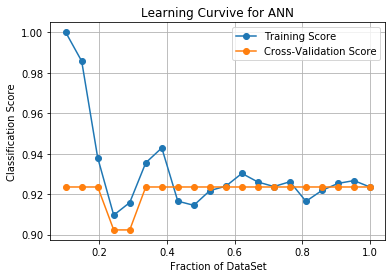

In [782]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_original, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

### Original Dataset with Labels

In [892]:
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)

y = y.apply(lambda q: 0 if q == 'B' else 1)

In [893]:
x_original = x
x_original['KMeans Labels'] = kmeans_labels
x_original['EM Labels'] = em_labels

print("Shape: ", x_original.shape)

Shape:  (569, 32)


Total Time Taken:  4.288708209991455
Testing Accuracy:  0.956140350877193


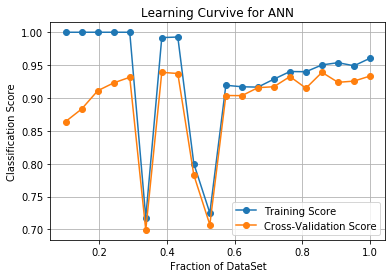

In [894]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_original, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

### PCA Dataset

In [895]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

In [896]:
transformer_pca = PCA(n_components=5, random_state=random_seed)
x_pca = transformer_pca.fit_transform(x)

classifier = KMeans(n_clusters=7, random_state=random_seed)
classifier.fit(x_pca)
kmeans_labels = classifier.labels_
print("K Means: ", len(kmeans_labels))

transformer_pca = PCA(n_components=2, random_state=random_seed)
x_pca = transformer_pca.fit_transform(x)
classifier = GaussianMixture(n_components=2, random_state=random_seed)
classifier.fit(x)
em_labels = classifier.predict(x)
print("EM: ", len(em_labels))

K Means:  569
EM:  569


In [897]:
x_original = pd.DataFrame()
x_original['KMeans Labels'] = kmeans_labels
x_original['EM Labels'] = em_labels
print("Shape: ", x_original.shape)

Shape:  (569, 2)


Total Time Taken:  5.638468265533447
Testing Accuracy:  0.9298245614035088


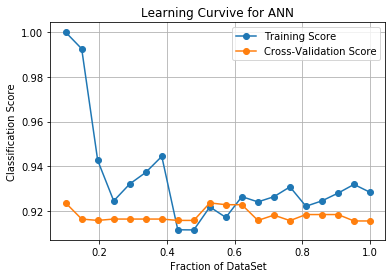

In [898]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_original, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

### ICA Dataset

In [794]:
data = pd.read_csv('data.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)
y = data['diagnosis']
x = data.drop(['diagnosis'], axis=1)
x = StandardScaler().fit_transform(x)
y = y.apply(lambda q: 0 if q == 'B' else 1)

In [795]:
transformer_ica = FastICA(n_components=3, random_state=random_seed)
x_ica = transformer_ica.fit_transform(x)

classifier = KMeans(n_clusters=7, random_state=random_seed)
classifier.fit(x_ica)
kmeans_labels = classifier.labels_
print("K Means: ", len(kmeans_labels))


transformer_ica = FastICA(n_components=2, random_state=random_seed)
x_ica = transformer_ica.fit_transform(x)
classifier = GaussianMixture(n_components=2, random_state=random_seed)
classifier.fit(x)
em_labels = classifier.predict(x)
print("EM: ", len(em_labels))

K Means:  569
EM:  569


Total Time Taken:  2.7331621646881104
Testing Accuracy:  0.6666666666666666


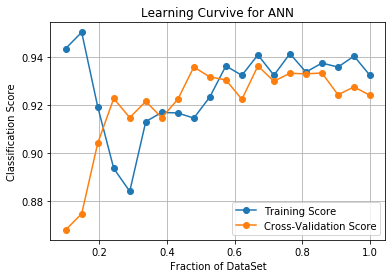

In [799]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_ica, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
#     y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
#     X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

### Random Projection